# IMPORTACIÓN LIBRERIAS


In [1]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
# from PIL import Image
import seaborn as sns
# import itertools
# import io 
# import plotly.offline as py
#py.init_notebook_mode(connect=True)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

# CARGA DE ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

Cargamos el archivo de pagos para trabajar con él

In [3]:
economia = load_dataset('../data/Pagaments per persona 01.09.2024 a 01.09.2025.xlsx')

# DEA

In [4]:
#Creamos copia para que no afecte en el archivo subido directamente
economia_eda= economia.copy()

In [5]:
economia_eda.columns

Index(['IdUsuario', 'IdRemesa', 'FechaRenovacion', 'TipoAbono',
       'FormaPagoMetálicoCantidad', 'FormaPagoMetálicoImporte',
       'FormaPagoMetálicoImporteCobrado',
       'FormaPagoRecibo_domiciliadoCantidad',
       'FormaPagoRecibo_domiciliadoImporte',
       'FormaPagoRecibo_domiciliadoImporteCobrado',
       'FormaPagoTarjeta_créditoCantidad', 'FormaPagoTarjeta_créditoImporte',
       'FormaPagoTarjeta_créditoImporteCobrado',
       'FormaPago_Transf_HortaEsportivaCantidad',
       'FormaPago_Transf_HortaEsportivaImporte',
       'FormaPago_Transf_HortaEsportivaImporteCobrado', 'TotalCantidad',
       'TotalImporte', 'TotalImporteCobrado'],
      dtype='object')

Al observar en el excel que ciertas columnas no nos pueden interesar porque no se pueden extraer features interesantes o porque los datos estan identicos se decide eliminar las siguentes columnas

In [7]:
economia_eda= economia_eda.drop(columns=[
    'IdRemesa', 'FormaPagoMetálicoCantidad','FormaPagoMetálicoImporte','FormaPagoRecibo_domiciliadoCantidad', 
        'FormaPagoRecibo_domiciliadoImporte', 'FormaPagoTarjeta_créditoCantidad','FormaPagoTarjeta_créditoImporte',
         'FormaPago_Transf_HortaEsportivaCantidad','FormaPago_Transf_HortaEsportivaImporte', 'TotalCantidad', 'TotalImporte'
         ])

economia_eda = economia_eda.rename(columns={
    'IdUsuario': 'IdPersona','FormaPagoMetálicoImporteCobrado': 'PagoMetálico','FormaPagoRecibo_domiciliadoImporteCobrado': 'PagoRecibo',
    'FormaPagoTarjeta_créditoImporteCobrado': 'PagoTarjeta','FormaPago_Transf_HortaEsportivaImporteCobrado': 'PagoTransferencia',  'TotalImporteCobrado': 'TotalCobrado'
        })

In [8]:
economia_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56970 entries, 0 to 56969
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IdPersona          56970 non-null  int64  
 1   FechaRenovacion    56970 non-null  object 
 2   TipoAbono          56970 non-null  object 
 3   PagoMetálico       56970 non-null  object 
 4   PagoRecibo         56970 non-null  object 
 5   PagoTarjeta        56970 non-null  object 
 6   PagoTransferencia  56970 non-null  object 
 7   TotalCobrado       56970 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.5+ MB


#### GESTIÓN DE TIPADO COLUMNAS

In [9]:
economia_eda['IdPersona'] = economia_eda['IdPersona'].astype(str)

In [10]:
cols_numericas = [ 'PagoMetálico',
       'PagoRecibo', 'PagoTarjeta', 'PagoTransferencia', 'TotalCobrado']

for col in cols_numericas:
    economia_eda[col] = pd.to_numeric(economia_eda[col], errors="coerce")

In [11]:
cols_fechas = ["FechaRenovacion"]

for col in cols_fechas:
    economia_eda[col] = pd.to_datetime(economia_eda[col], errors="coerce", dayfirst=True)

In [12]:
# Identify numeric and categorical variables
print("\n📋 Variable Types:")

# Numeric variables
num_vbles_df = economia_eda.select_dtypes(include='number').columns.tolist()

# Categorical variables
cat_vbles_df = economia_eda.select_dtypes(exclude='number').columns.tolist()

print(f"Numeric variables: {num_vbles_df}")
print(f"Categorical variables: {cat_vbles_df}")


📋 Variable Types:
Numeric variables: ['PagoMetálico', 'PagoRecibo', 'PagoTarjeta', 'PagoTransferencia', 'TotalCobrado']
Categorical variables: ['IdPersona', 'FechaRenovacion', 'TipoAbono']


##### ¿Hay duplicados?

In [13]:
print("\n🔍 Duplicate Rows:")

# Count how many rows are duplicates
duplicated_rows = economia_eda.duplicated().sum()
if duplicated_rows > 0:
    print("🔴 Duplicate Rows:")
    display(economia_eda[economia_eda.duplicated()])  # Show duplicate rows
else:
    print('No duplicate rows')

# Check for duplicate columns
print("\n🔍 Duplicate Columns:")

# Transpose the abonado_altasFrame to check for duplicate columns
duplicated_columns = economia_eda.T.duplicated().sum()
if duplicated_columns > 0:
    display(economia_eda[economia_eda.duplicated()])  # Show duplicate columns
else:
    print('No duplicate columns')


🔍 Duplicate Rows:
🔴 Duplicate Rows:


,IdPersona,FechaRenovacion,TipoAbono,PagoMetálico,PagoRecibo,PagoTarjeta,PagoTransferencia,TotalCobrado
7364,47161,2025-08-01,EMP1 - EMPLEATS D'ALTRES EMPRESES,0.0,NaN,NaN,NaN,0.0



🔍 Duplicate Columns:
No duplicate columns


Al tener esa fila duplicada y sabiendo que eliminaremos como en los otros casos los abonados con esta tipologia de abono no nos importa tratarlo ahora mismo.

##### ¿Hay nulos?

-PRE


📌 Variables with missing values:


,Total Missing,Percentage Missing
PagoTransferencia,56961,99.984202
PagoTarjeta,56155,98.569423
PagoMetálico,49301,86.538529
PagoRecibo,8493,14.907846


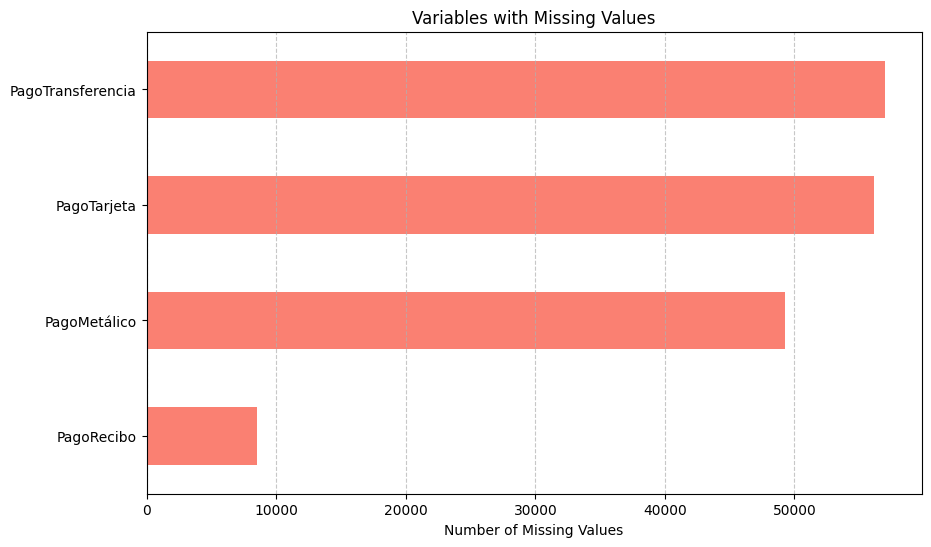

In [14]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = economia_eda.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(economia_eda)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")

Se entiende que la mayoria de nulos es porque hay datos faltantes en las columnas, interpretando el dataframe es que si no hay dato es un 0, es decir no hay pago por parte del cliente. 

Se substituyen los nan por un 0


-POST

In [15]:
economia_eda= economia_eda.fillna(0)

In [16]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = economia_eda.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(economia_eda)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")


📌 Variables with missing values:
✅ No missing values in the dataset.


#### -FEATURE ENGINEERING 

Se realiza como en el archivo de abonados una pequeño filtro. Se excluyen los abonados que se han dado de baja que no forman parte y no interfieren directamente al numero de socios. Tal como los abonados con abonos antiguos, que no pagan, y también empleados del gimnasio.

In [ ]:
tipos_a_excluir = ["EMP0 - EMPLEADOS CLUB SIN CUOTA", "EMP1 - EMPLEATS D'ALTRES EMPRESES", "CL02 - SOCIS NUMERARIS", "CL01 - SOCIS D'HONOR"]
economia_eda_filtrado = economia_eda[~economia_eda['TipoAbono'].isin(tipos_a_excluir)].reset_index(drop=True)

In [18]:
df_features= economia_eda_filtrado.copy()

Se realiza un mapeo de cmabio de nombre de abono y se realizan los diferentes calculos para las nuevas columnas de comportamiento por esa parte

| AbonoOriginal                                               | CodigoAbono |
|-------------------------------------------------------------|-------------|
| AA00 - ADULTS ( 26 A 64 ANYS )                              | AA00        |
| AR00 - TARJA ROSA (TARJETA GRATUÏTA)                        | AR00        |
| JO00 - QUOTA DESCOMPTE JOVE (DE 18 A 25 ANYS)               | JO00        |
| AG00 - GENT GRAN (MES DE 65 ANYS)                           | AG00        |
| AT01 - ATUR TOTAL                                           | AT01        |
| AF00 - ADULTS C.S. (DIVENDRES TARDA MES CAP DE...           | AF00        |
| MA00 - ADULTS MATINS ( DE 7 A 16 MES CAPS DE S...           | MA00        |
| CR01 - CARNET ROSA (TARJETA REDUÏDA)                        | CR01        |
| FAMILIAR (PARES MES ELS MENORS DE 18 ANYS)                  | FA00        |
| QUOTA MANTENIMENT - MENSUAL                                 | QM01        |
| AG03 - GENT GRAN - TRIMESTRAL                               | AG03        |
| AM00 - INFANTIL (DE 6 A 17 ANYS)                             | AM00        |
| ATURATS MATI                                                | AT00        |
| AT00 - ATUR MATI                                            | AT00        |
| AC00 - COMERCIANTS (DE 7 A 9 I DE 13 A 17 MES ...            | AC00        |
| TEMP                                                        | TMP         |
| AA03 - ADULTS - TRIMESTRAL                                  | AA03        |
| MA03 - ADULTS MATINS - TRIMESTRAL                           | MA03        |
| AA12 - ADULTS - ANUAL                                       | AA12        |
| ATURATS TOTAL                                               | AT01        |
| FAMILIAR MONOPARENTAL (AMB CARNET MONOPARENTAL)             | FM01        |
| AR03 - TARJA ROSA - TRIMESTRAL                              | AR03        |
| MA06 - ADULTS MATINS - SEMESTRAL                            | MA06        |
| AVET - ABONATS VETERANS                                     | AVET        |
| AC03 - COMERCIANTS - TRIMESTRAL                             | AC03        |
| JO03 - QUOTA TRIMESTRAL JOVE                                | JO03        |
| FAMILIAR ANUAL                                              | FA12        |
| AP03 - PREINFANTIL3-5                                       | AP03        |
| AP00 - PREINFANTIL0-2                                       | AP00        |
| AF03 - ADULTS C.S - TRIMESTRAL                              | AF03        |
| AG12 - GENT GRAN - ANUAL                                    | AG12        |
| AM03 - INFANTIL-TRIMESTRAL                                  | AM03        |
| EMPF - FAMILIAR EMPLEADO                                    | EMPF        |
| CR03 - CARNET ROSA - TRIMESTRAL                             | CR03        |
| NI00 - ADULTS NITS                                          | NI00        |
| VIP                                                         | VIP         |
| CL04 - JUBILATS SENSE DRET A US                             | CL04        |
| QUOTA MANTENIMENT - TRIM.                                   | QM03        |
| MA12 - ADULTS MATINS ANUALS                                 | MA12        |
| AR12 - TARJA ROSA - ANUAL                                   | AR12        |
| APG03-GROUPON-SEMESTRAL                                     | APG03        |
| APG04-GROUPON-ANUAL                                     | APG04        |
| T07 - QUOTA I-10                                     | T07        |
| T12 - QUOTA TR-25                                     | T12        |
| T14 - QUOTA TR-15                                     | T14        |
| T16 - QUOTA                                     | T16        |
| T15 - QUOTA TR-10                                     | T15        |



In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import re

# Regex para detectar códigos como "XXXX - ..."
patron_codigo = re.compile(r"^([A-Z0-9]{4})\s-\s")

# Diccionario de códigos manuales para los que no tienen formato
mapeo_manual = {
    'FAMILIAR (PARES MES ELS MENORS DE 18 ANYS)': 'FA00',
    'QUOTA MANTENIMENT - MENSUAL': 'QM01',
    'FAMILIAR MONOPARENTAL (AMB CARNET MONOPARENTAL)': 'FM01',
    'TEMP': 'TEMP',
    'VIP': 'VIP',
    'FAMILIAR ANUAL': 'FA12',
    'QUOTA MANTENIMENT - TRIM.': 'QM03',
    'ATURATS TOTAL': 'AT01',
    'ATURATS MATI': 'AT00',
    "AA0 - PROMO 9'90€ (PRIMER MES)": 'AA0',
    "APG03-GROUPON-SEMESTRAL": 'APG03',
    "APG04-GROUPON-ANUAL": 'APG04',
    "T07 - QUOTA I-10": 'T07',
    "T12 - QUOTA TR-25": 'T12',
    "T14 - QUOTA TR-15": 'T14',
    "T16 - QUOTA": 'T16',
    "T15 - QUOTA TR-10": 'T15'
}

# Función de limpieza que puedes aplicar a cualquier columna
def extraer_codigo_abono(abono):
    if pd.isna(abono):
        return None
    match = patron_codigo.match(abono)
    if match:
        return match.group(1)
    return mapeo_manual.get(abono, abono)  # Si no hay código, mira si está en el mapeo

# Aplicar a la columna deseada
df_features['TipoAbono'] = df_features['TipoAbono'].apply(extraer_codigo_abono)
# ----------------------------
# 1. Preparación inicial datos
# ----------------------------

# Asegurar formato datetime y ordenar por cliente y fecha
df_features['FechaRenovacion'] = pd.to_datetime(df_features['FechaRenovacion'])
df_features = df_features.sort_values(['IdPersona', 'FechaRenovacion'])

# ----------------------------
# 2. Cálculo de features básicas por cliente
# ----------------------------

# Tipo de abono inicial y final
tipo_abono_inicial = df_features.groupby('IdPersona').first()['TipoAbono'].rename('TipoAbonoInicial')
tipo_abono_final = df_features.groupby('IdPersona').last()['TipoAbono'].rename('TipoAbonoFinal')

# Métricas agregadas por cliente
resumen = df_features.groupby('IdPersona').agg({
    'FechaRenovacion': ['min', 'max', 'count'],
    'TipoAbono': pd.Series.nunique,
    'TotalCobrado': ['sum', 'mean', 'max', 'min'],
    'PagoMetálico': 'sum',
    'PagoRecibo': 'sum',
    'PagoTarjeta': 'sum',
    'PagoTransferencia': 'sum'
})

# Aplanar columnas multi-nivel y renombrar
resumen.columns = ['{}_{}'.format(col[0], col[1]) if isinstance(col, tuple) else col for col in resumen.columns]
resumen = resumen.rename(columns={
    'FechaRenovacion_min': 'PrimeraRenovacion',
    'FechaRenovacion_max': 'UltimaRenovacion',
    'FechaRenovacion_count': 'NumRenovaciones',
    'TipoAbono_nunique': 'NumTiposAbono',
    'TotalCobrado_sum': 'TotalPagado',
    'TotalCobrado_mean': 'MediaPagada',
    'TotalCobrado_max': 'MaximoPagada',
    'TotalCobrado_min': 'MinimaPagada',
    'PagoMetálico_sum': 'TotalMetálico',
    'PagoRecibo_sum': 'TotalRecibo',
    'PagoTarjeta_sum': 'TotalTarjeta',
    'PagoTransferencia_sum': 'TotalTransferencia'
})
resumen = resumen.reset_index()

# ----------------------------
# 3. Features adicionales basados en datos agregados
# ----------------------------

# Marcar si hubo cambio de abono
resumen['CambioAbono'] = resumen['NumTiposAbono'] > 1

# Ratio de meses pagados (suponiendo 12 meses de referencia)
resumen['RatioMesesPagados'] = resumen['NumRenovaciones'] / 12

# Variación aproximada del importe pagado
resumen['VarImporteAprox'] = resumen['MaximoPagada'] - resumen['MinimaPagada']

# Coeficiente de variación del importe pagado (variación relativa)
resumen['CefVarImporte'] = resumen.apply(
    lambda row: (row['MaximoPagada'] - row['MinimaPagada']) / row['MediaPagada']
    if row['MediaPagada'] and row['MediaPagada'] != 0 else np.nan,
    axis=1
)

# ----------------------------
# 4. Fechas relativas y forma de pago mayoritaria
# ----------------------------

fecha_corte = pd.to_datetime("2025-09-01")

# Convertir primero a datetime
resumen['PrimeraRenovacion'] = pd.to_datetime(resumen['PrimeraRenovacion'])
resumen['UltimaRenovacion'] = pd.to_datetime(resumen['UltimaRenovacion'])

# Último mes pagado en formato period (YYYY-MM)
resumen["UltimoMesPagado"] = resumen["UltimaRenovacion"].dt.to_period("M").astype(str)
resumen['UltimoAñoPagado'] = resumen['UltimoMesPagado'].str.split('-').str[0].astype(int)
resumen['UltimoMesPagadoNum'] = resumen['UltimoMesPagado'].str.split('-').str[1].astype(int)

# Meses desde último y primer pago (respecto a fecha_corte)
resumen["MesesDesdeUltimoPago"] = (
    (fecha_corte.year - resumen["UltimaRenovacion"].dt.year) * 12 +
    (fecha_corte.month - resumen["UltimaRenovacion"].dt.month)
)

resumen["MesesDesdePrimerPago"] = (
    (fecha_corte.year - resumen["PrimeraRenovacion"].dt.year) * 12 +
    (fecha_corte.month - resumen["PrimeraRenovacion"].dt.month)
)


# Duración entre primera y última renovación en meses (aproximado)
resumen['DuracionRenovacionMeses'] = (resumen['UltimaRenovacion'] - resumen['PrimeraRenovacion']).dt.days / 30.44


# Forma de pago mayoritaria (la que suma más)
formas_pago = ['TotalMetálico', 'TotalRecibo', 'TotalTarjeta', 'TotalTransferencia']
resumen['FormaPagoMayoritaria'] = resumen[formas_pago].idxmax(axis=1).str.replace('Total', '')

# ----------------------------
# 5. Incorporar tipo de abono inicial y final al resumen
# ----------------------------

resumen = resumen.merge(tipo_abono_inicial, on='IdPersona', how='left')
resumen = resumen.merge(tipo_abono_final, on='IdPersona', how='left')

# ----------------------------
# 6. Total pagado por tipo de abono (pivot)
# ----------------------------

totales_abono = df_features.groupby(['IdPersona', 'TipoAbono'])['TotalCobrado'].sum().reset_index()
abono_pivot = totales_abono.pivot(index='IdPersona', columns='TipoAbono', values='TotalCobrado')
abono_pivot.columns = [f'TotalAbono_{col}' for col in abono_pivot.columns]
abono_pivot = abono_pivot.reset_index()

resumen = resumen.merge(abono_pivot, on='IdPersona', how='left')

# Tipo de abono más frecuente y número de cambios de abono
tipo_abono_frecuente = df_features.groupby('IdPersona')['TipoAbono'].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    ).rename('TipoAbonoFrecuente')
resumen = resumen.merge(tipo_abono_frecuente, on='IdPersona', how='left')

cambios_abono = df_features.groupby('IdPersona')['TipoAbono'].apply(
        lambda x: (x != x.shift()).sum() - 1
    ).rename('NumCambiosAbono')
resumen = resumen.merge(cambios_abono, on='IdPersona', how='left')

# ----------------------------
# 7. Cálculo de tendencia de pago mediante regresión lineal
# ----------------------------

def calcular_tendencia(df_cliente):
    df_cliente = df_cliente.sort_values('FechaRenovacion')
    df_cliente['dias'] = (df_cliente['FechaRenovacion'] - df_cliente['FechaRenovacion'].min()).dt.days
    X = df_cliente[['dias']]
    y = df_cliente['TotalCobrado']
    if len(X) > 1:
        modelo = LinearRegression().fit(X, y)
        return modelo.coef_[0]
    else:
        return np.nan

# Tendencia general por cliente
tendencia_general = df_features.groupby('IdPersona').apply(calcular_tendencia).reset_index(name='TendenciaPago')

# Tendencia para clientes sin cambio de abono
clientes_estables = resumen[resumen['CambioAbono'] == False]['IdPersona']
df_estables = df_features[df_features['IdPersona'].isin(clientes_estables)]
tendencia_estable = df_estables.groupby('IdPersona').apply(calcular_tendencia).reset_index(name='TendenciaPagoMismoAbono')

# Unir tendencias al resumen
resumen = resumen.merge(tendencia_general, on='IdPersona', how='left')
resumen = resumen.merge(tendencia_estable, on='IdPersona', how='left')

# ----------------------------
# 8. Detección de impagos y reactivaciones
# ----------------------------

def detectar_impagos(df):
    df = df.sort_values('FechaRenovacion').copy()
    df['MesDiff'] = df['FechaRenovacion'].diff().dt.days.div(30).fillna(0).astype(int)
    df['CambioAbono'] = df['TipoAbono'] != df['TipoAbono'].shift()

    salto = df['MesDiff'] > 1
    impago = salto & (~df['CambioAbono'])
    reactivacion = salto & df['CambioAbono']

    return pd.Series({
        'NumImpagosReales': impago.sum(),
        'NumReactivaciones': reactivacion.sum(),
        'PagoSinSaltos': (df['MesDiff'].iloc[1:] <= 1).all()
    })

impagos = df_features.groupby('IdPersona').apply(detectar_impagos).reset_index()

# Unir detección de impagos al resumen final
resumen = resumen.merge(impagos, on='IdPersona', how='left')
resumen['CambioAbono'] = resumen['CambioAbono'].astype(int)
resumen['PagoSinSaltos'] = resumen['PagoSinSaltos'].astype(int)


In [24]:
# Utilizamos esta linea de codigo para poder ver todas las columnas del dataframe
pd.set_option('display.max_columns', None)

In [25]:
# Seleccionamos las columnas que contienen 'TotalAbono_'
cols_abonos = [col for col in resumen.columns if 'TotalAbono_' in col]

# Reemplazamos NaN por 0 en esas columnas
resumen[cols_abonos] = resumen[cols_abonos].fillna(0)
resumen['TendenciaPago'] = resumen['TendenciaPago'].fillna(0)
resumen['TendenciaPagoMismoAbono'] = resumen['TendenciaPagoMismoAbono'].fillna(0)
resumen['CefVarImporte'] = resumen['CefVarImporte'].fillna(0)
resumen = resumen.drop(columns=['PrimeraRenovacion', 'UltimaRenovacion', 'MaximoPagada','MinimaPagada',
                        'VarImporteAprox','UltimoMesPagado', 'UltimoAñoPagado', 'UltimoMesPagadoNum' ])
resumen

,IdPersona,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,PagoSinSaltos
0,100013,1,1,59.95,59.950000,0.0,59.95,0.00,0.0,0,0.083333,0.000000,0,0,0.000000,Recibo,AA00,AA00,0.0,59.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AA00,0,0.000000,0.000000,0,0,1
1,100037,12,2,319.65,26.637500,0.0,319.65,0.00,0.0,1,1.000000,0.885969,0,11,11.005256,Recibo,AR00,QM01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,291.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.75,0.0,0.0,0.0,AR00,1,-0.069630,0.000000,0,0,1
2,100043,12,1,559.20,46.600000,0.0,513.50,45.70,0.0,0,1.000000,0.025751,0,11,11.005256,Recibo,JO00,JO00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,559.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,JO00,0,0.003734,0.003734,0,0,1
3,100060,12,1,712.50,59.375000,0.0,712.50,0.00,0.0,0,1.000000,0.038737,0,11,11.005256,Recibo,AA00,AA00,0.0,712.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AA00,0,0.007156,0.007156,0,0,1
4,100062,12,1,458.70,38.225000,0.0,458.70,0.00,0.0,0,1.000000,0.039241,0,11,11.005256,Recibo,AG00,AG00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,458.7,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AG00,0,0.004667,0.004667,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,99961,12,1,0.00,0.000000,0.0,0.00,0.00,0.0,0,1.000000,0.000000,0,11,11.005256,Metálico,FA00,FA00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,FA00,0,0.000000,0.000000,0,0,1
7170,99962,12,2,1039.42,86.618333,0.0,0.00,1039.42,0.0,1,1.000000,1.085567,0,11,11.005256,Tarjeta,FA00,FA00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1020.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.50,0.0,0.0,0.0,FA00,2,-0.160827,0.000000,0,0,1
7171,99983,12,1,458.70,38.225000,0.0,458.70,0.00,0.0,0,1.000000,0.039241,0,11,11.005256,Recibo,AG00,AG00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,458.7,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AG00,0,0.004667,0.004667,0,0,1
7172,99997,12,1,458.70,38.225000,0.0,458.70,0.00,0.0,0,1.000000,0.039241,0,11,11.005256,Recibo,AG00,AG00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,458.7,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AG00,0,0.004667,0.004667,0,0,1


Estudiamos si hay la posibilidad de descartar algunas columnas que podrian estar correlacionadas 

In [26]:
correlacion_media_total = resumen['MediaPagada'].corr(resumen['TotalPagado'])
print(f"Correlación entre MediaPagada y TotalPagado: {correlacion_media_total:.4f}")

correlacion_duracion_primero = resumen['DuracionRenovacionMeses'].corr(resumen['MesesDesdePrimerPago'])
print(f"Correlación entre DuracionRenovacionMeses y MesesDesdePrimerPago: {correlacion_duracion_primero:.4f}")

Correlación entre MediaPagada y TotalPagado: 0.4667
Correlación entre DuracionRenovacionMeses y MesesDesdePrimerPago: 0.6694


No estan altamente correlacionadas, la decisión es mantenerlas 

# GUARDAMOS DATAFRAME RESULTANTE 

Ese dataframe se guarda para reutilizarse posteriormente para crear el archivo final para el modelo. Se guarda en formato CSV.

Comentario: Faltan criterios de preparación del dataframe para el modelo, se hace posteriormente en el notebook de archivo final

In [27]:
# Guardar el DataFrame en un archivo CSV
resumen.to_csv('../data/economia_final.csv', index=False)